In [195]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [196]:
plt.style.use("paper.mplstyle")

In [197]:
def load_case_results(this_case_folder):
    wave_name = 'wave'
    solar_name = ['utilitypv','solar_photovoltaic']
    onshore_wind_name = ['onshore_wind','landbasedwind']
    offshore_wind_name = ['offshore_wind','offshorewind']
    battery_name = ['battery','batteries']
    fossil_name = ['coal','natural_gas','peaker','naturalgas']

    case_result_folder = os.path.join(this_case_folder,'results','results_p1')
    cost_file     = os.path.join(case_result_folder,'costs.csv')
    carbon_file   = os.path.join(case_result_folder,'emissions.csv')
    capacity_file = os.path.join(case_result_folder,'capacity.csv')
    energy_file   = os.path.join(case_result_folder,'capacityfactor.csv')

    system_cost_df   = pd.read_csv(cost_file,     index_col='Costs') # units: presumably dollars, need to double check
    carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3) # units: tonnes CO2
    capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap','NewCap']) # units: MW
    energy_df = pd.read_csv(energy_file, index_col='Resource', usecols=['Resource','AnnualSum']) # units: MWh

    system_cost = system_cost_df['Total'].loc['cTotal']
    carbon = carbon_df['Total'].loc['AnnualSum']
    system_capacity = capacity_df['EndCap'].loc['Total']
    
    wave_idx = capacity_df.index.str.contains(wave_name, regex=True)
    wave_capacity = capacity_df['NewCap'].loc[wave_idx].sum()
    pct_wave_capacity = wave_capacity / system_capacity

    solar_idx = capacity_df.index.str.contains('|'.join(solar_name), regex=True)
    solar_capacity = sum(capacity_df['NewCap'].loc[solar_idx])
    pct_solar_capacity = solar_capacity / system_capacity

    onshore_wind_idx = capacity_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
    onshore_wind_capacity = sum(capacity_df['NewCap'].loc[onshore_wind_idx])
    pct_onshore_wind_capacity = onshore_wind_capacity / system_capacity

    offshore_wind_idx = capacity_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
    offshore_wind_capacity = sum(capacity_df['NewCap'].loc[offshore_wind_idx])
    pct_offshore_wind_capacity = offshore_wind_capacity / system_capacity

    battery_idx = capacity_df.index.str.contains('|'.join(battery_name), regex=True)
    battery_capacity = sum(capacity_df['NewCap'].loc[battery_idx])
    pct_battery_capacity = battery_capacity / system_capacity

    fossil_idx = capacity_df.index.str.contains('|'.join(fossil_name), regex=True)
    fossil_capacity = sum(capacity_df['NewCap'].loc[fossil_idx])
    pct_fossil_capacity = fossil_capacity / system_capacity

    fossil_idx = energy_df.index.str.contains('|'.join(fossil_name), regex=True)
    fossil_energy = energy_df['AnnualSum'].loc[fossil_idx].sum()

    wave_idx = energy_df.index.str.contains(wave_name, regex=True)
    wave_energy = energy_df['AnnualSum'].loc[wave_idx].sum()

    # input costs for other resources
    input_folder = os.path.join(this_case_folder, 'inputs', 'inputs_p1')
    vre_file = os.path.join(input_folder, 'resources','Vre.csv')
    vre_df = pd.read_csv(vre_file, index_col='Resource',usecols=['Resource','capex_mw'])

    solar_idx = vre_df.index.str.contains('|'.join(solar_name), regex=True)
    solar_costs = np.unique(vre_df['capex_mw'].loc[solar_idx])

    onshore_wind_idx = vre_df.index.str.contains('|'.join(onshore_wind_name), regex=True)
    onshore_wind_costs = np.unique(vre_df['capex_mw'].loc[onshore_wind_idx])

    offshore_wind_idx = vre_df.index.str.contains('|'.join(offshore_wind_name), regex=True)
    offshore_wind_costs = np.unique(vre_df['capex_mw'].loc[offshore_wind_idx])

    battery_file = os.path.join(input_folder, 'resources', 'Storage.csv')
    battery_df = pd.read_csv(battery_file, index_col='Resource', usecols=['Resource', 'capex_mw'])
    battery_idx = battery_df.index.str.contains('|'.join(battery_name), regex=True)
    battery_costs = np.unique(battery_df['capex_mw'].loc[battery_idx])

    fossil_file = os.path.join(input_folder, 'resources', 'Thermal.csv')
    fossil_df = pd.read_csv(fossil_file, index_col='Resource', usecols=['Resource', 'capex_mw'])
    fossil_idx = fossil_df.index.str.contains('|'.join(fossil_name), regex=True)
    fossil_costs = np.unique(fossil_df['capex_mw'].loc[fossil_idx])

    outputs = [system_cost, carbon, system_capacity,\
                wave_capacity, solar_capacity, onshore_wind_capacity,\
                offshore_wind_capacity, battery_capacity, fossil_capacity,
                solar_costs, onshore_wind_costs, offshore_wind_costs,\
                battery_costs, fossil_costs, fossil_energy, wave_energy]
    return outputs


In [198]:
def plot_single_grid_scenario(in_and_out, output_cols, output_scale):
    # function to plot results for one grid scenario swept over various WEC inputs
    wec_cost = in_and_out['wec_cost'].values
    power_lim = in_and_out['power_lim'].values
    diameter = in_and_out['diameter'].values
    omega_n = in_and_out['omega_n'].values
    zeta = in_and_out['zeta'].values

    # determine size for reshaping
    num_costs = len(np.unique(wec_cost))
    num_power_limits = len(np.unique(power_lim))
    num_diameters = len(np.unique(diameter))
    num_omega_n = len(np.unique(omega_n))
    num_zeta = len(np.unique(zeta))
    size_array = np.array([num_diameters, num_power_limits, num_zeta, num_omega_n, num_costs ])
    size_tuple = tuple(size_array[size_array > 1]) # remove dimensions of 1s

    # reshape inputs for plotting
    # wec_cost = np.reshape(wec_cost, size_tuple)
    # power_lim = np.reshape(power_lim, size_tuple)
    # diameter = np.reshape(diameter, size_tuple)
    # omega_n = np.reshape(omega_n, size_tuple)
    # zeta = np.reshape(zeta, size_tuple)

    # hardcoded based on result - in the future do this programatically
    x = 250/8
    points = np.array([[300+x,   0.03],
                       [300-x,   0.03],
                       [300-x,   0.05],
                       [300-3*x, 0.05],
                       [300-3*x, 0.09],
                       [300-5*x, 0.09],
                       [300-5*x, 0.11],
                       [300+x,   0.11],
                       [300+x,   0.03]])
    inflation = 1.36 # 2014 to 2025
    show_all_x = True
    if show_all_x:
        ok_low = np.min(wec_cost)
        ok_high = np.max(wec_cost)
    else:
        ok_low = 525
        ok_high = 725
    
    RM3_cost = 1.301e6 * inflation # $k/MW
    cost_to_norm_by = np.max(wec_cost)
    ok_idx = (wec_cost >= ok_low) & (wec_cost <= ok_high) # results outside this range look weird
    n_dims = np.sum(np.array(size_tuple) > 1)
    if n_dims == 1 and num_costs > 1:
        # line plot with cost on x-axis
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(4,5.2), sharex=True, height_ratios=[1, 2])
        next(ax[1]._get_lines.prop_cycler)
        next(ax[1]._get_lines.prop_cycler) # start capacity plot at third color to not overlap with cost plot
        for output in output_cols:
            output_reshaped = np.reshape(in_and_out[output].values, size_tuple)
            y_units = False
            if y_units:
                scale = 1/output_scale[output]
            else:
                output_to_scale_by = output_reshaped[wec_cost==cost_to_norm_by]
                if output_to_scale_by == 0: # avoid division by zero
                    output_to_scale_by = 1
                scale = 1/output_to_scale_by # normalize by end of graph
            if 'capacity' in output:
                ax_idx = 1
                label_slice = slice(0, -1)
            elif 'costs' in output:
                ax_idx = 1
                label_slice = slice(None)
            else:
                ax_idx = 0
                label_slice = slice(None)
            if 'offshore_wind' not in output:
                label_str = ' '.join(output.rsplit('_')[label_slice]).title()
                label_str = label_str.replace('Onshore ', '')
                plot_cost = False
                if 'costs' not in output: # capacity and system
                    val = output_reshaped*scale
                    
                    ax[ax_idx].plot(wec_cost[ok_idx]*inflation, val[ok_idx], '.-', label=label_str)
                
                elif 'costs' in output and plot_cost == True:
                    if output == 'solar_costs':
                        for _ in range(6):
                            next(ax[ax_idx]._get_lines.prop_cycler) # skip colors for costs
                    # cost dashed lines
                    x_costs = output_reshaped[0] / 1e3
                    for x_cost in x_costs[0]:
                        if x_cost != 0:
                            ax[ax_idx].plot([x_cost,x_cost],[0, 5], '--', label=label_str)

        if y_units:
            units_cost = '(\$M)' # fixme this should depend on scale and is probably inaccurate for the current scale
            units_capacity = '(MW)'
        else:
            units_cost = '(normalized)'
            units_capacity = '(normalized)'
        ax[1].set_xlabel('WEC Investment Cost (\$k/MW)')
        ax[0].set_ylabel('Cost ' + units_cost)
        ax[1].set_ylabel('Capacity ' + units_capacity)
        plt.xlim([ok_low*inflation, ok_high*inflation])
        ax[0].legend()
        ax[1].legend()
        ax[0].grid()
        ax[1].grid()
    elif n_dims == 2 and num_power_limits>1 and num_costs>1:
        # contour plots in power limit and cost space
        for output in output_cols:
            output_reshaped = np.reshape(in_and_out[output].values, size_tuple)
            fig, ax = plt.subplots()
            plt.pcolormesh(wec_cost, power_lim, output_reshaped.astype(float))
            #plt.plot(points[:,0],points[:,1],'r')
            plt.title(output)
            plt.xlabel('WEC Investment Cost (\$k/MW)')
            plt.ylabel('WEC Fractional Power Limit')
            plt.colorbar()
    elif n_dims == 4 and num_diameters==1:
        # 2D zeta-omega_n grid of power-cost contour plots
        for output in output_cols:
            if 'costs' not in output:
                n_cols = 2 # num_omega_n
                fig, ax = plt.subplots(nrows=num_zeta, ncols=n_cols, figsize=(8, 6), sharex=True, sharey=True)
                fig.suptitle(output.title().replace('_', ' '))
                fig.supxlabel('WEC Investment Cost (\$k/MW)')
                fig.supylabel('WEC Fractional Power Limit')

                vmin=0 # np.nanmin(in_and_out[output].values)
                
                if 'system_cost' in output:
                    vmax=3e9
                elif 'carbon' in output:
                    vmax=1.3e7
                elif 'capacity' in output:
                    vmax=10000 # np.nanmax(in_and_out[output].values)
                for z_idx, zeta_val in enumerate(np.unique(zeta)):
                    for o_idx, omega_n_val in enumerate([0.5,0.6]):#enumerate(np.unique(omega_n)):
                        idxs = np.logical_and(zeta==zeta_val, omega_n==omega_n_val)
                        new_shape = (num_power_limits, num_costs)
                        cost = np.reshape(wec_cost[idxs], new_shape)
                        pow = np.reshape(power_lim[idxs], new_shape) / 1e3
                        out = np.reshape(in_and_out[output].values[idxs], new_shape).astype(float)
                        h = ax[z_idx,o_idx].pcolormesh(cost, pow, out, vmin=vmin, vmax=vmax)
                        if o_idx == 0:
                            ax[z_idx,o_idx].set_ylabel(f'$\zeta={zeta_val}$')
                        if z_idx == num_zeta - 1:
                            ax[z_idx,o_idx].set_xlabel(f'$\omega_n={omega_n_val}$')
                fig.colorbar(h, ax=ax, orientation='vertical')

    else:
        raise ValueError("Unexpected number of dimensions in input data.")
    plt.savefig("CEM_cost_sweep.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [199]:
def plot_no_WEC_vs_grid_scenario(in_and_out, output_cols, output_scale):
    # group by grid scenarios
    #inputs_grouped = in_and_out.groupby(['electrification', 'carbon_constraint', 'year']).first().reset_index()
    pass

In [200]:
def all_plots_for_location(in_and_out, output_cols):
    output_scale = {'system_cost': 1e7, 'carbon': 1e4, 'system_capacity': 100, \
                    'wave_capacity': 100, 'solar_capacity': 100, \
                    'onshore_wind_capacity': 100, 'offshore_wind_capacity': 100, \
                    'battery_capacity': 100, 'fossil_capacity': 100}
    # plot no-WEC results vs grid scenario
    plot_no_WEC_vs_grid_scenario(in_and_out, output_cols, output_scale)

    # plot results vs WEC design for each grid scenario
    num_grid_scenarios = 1
    for i in range(num_grid_scenarios):
        plot_single_grid_scenario(in_and_out, output_cols, output_scale)

In [201]:
def make_inputs_outputs(location, output_cols):
    inputs = pd.read_csv(os.path.join(location,'scenario_input.csv'))

    this_loc_cases_folder = os.path.join(location,'cases')

    outputs = pd.DataFrame(index=inputs.index, columns=output_cols)

    # extract outputs
    case_folders = [os.path.join(this_loc_cases_folder, case_id) for case_id in inputs['case_id']]
    
    for idx, case_folder in enumerate(case_folders):
        if os.path.exists(os.path.join(case_folder,'results')):
            try:
                outputs.loc[idx] = load_case_results(case_folder)
            except:
                print(f"Error processing case folder {case_folder}. Skipping.")
        else:
            print(f"Warning: Case folder {case_folder} does not exist. Skipping.")
            outputs.loc[idx] = [np.nan] * len(output_cols)

    outputs.reset_index(drop=True, inplace=True)
    print(f"Outputs for {this_loc_cases_folder}:")
    print(outputs)

    # extract and clean inputs
    wec_cost_str = inputs.wave_cost.values
    wec_cost = np.array([float(c.rsplit('_')[-1]) for c in wec_cost_str])
    wave_variability = inputs.wave_variability.values
    power_lim = np.array([float(v.rsplit('_')[-1]) for v in wave_variability])
    diameter  = np.array([float(v.rsplit('_')[-3]) for v in wave_variability])
    omega_n   = np.array([float(v.rsplit('_')[-6]) for v in wave_variability])
    zeta      = np.array([float(v.rsplit('_')[2])  for v in wave_variability])

    cleaned_inputs = pd.DataFrame(index=inputs.index, \
                                columns=['wec_cost', 'power_lim', 'diameter', 'omega_n', 'zeta'], \
                                data=np.array([wec_cost, power_lim, diameter, omega_n, zeta]).T)
    cleaned_inputs['electrification'] = inputs['electrification']
    cleaned_inputs['carbon_constraint'] = inputs['carbon_constraint']
    cleaned_inputs['year'] = inputs['year']

    # combine inputs and outputs and save
    in_and_out = pd.concat([cleaned_inputs, outputs], axis=1)
    return in_and_out

In [202]:
def process_one_location(location):
    output_cols = ['system_cost', 'carbon', 'system_capacity','wave_capacity', 'solar_capacity', \
            'onshore_wind_capacity', 'offshore_wind_capacity', 'battery_capacity','fossil_capacity',
            'solar_costs', 'onshore_wind_costs', 'offshore_wind_costs',
            'battery_costs', 'fossil_costs','fossil_energy', 'wave_energy'] 
    
    output_path = os.path.join(location, 'scenario_outputs.csv')
    # if os.path.exists(output_path):
    #     in_and_out = pd.read_csv(output_path)
    # else:
    in_and_out = make_inputs_outputs(location, output_cols)
    in_and_out.to_csv(output_path, index=False)

    all_plots_for_location(in_and_out, output_cols)



/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)
/home/becca/miniconda3/envs/wec-decider-decider-2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:940: VisibleDeprecationWarning: Creating an ndarray from ragg

Outputs for data_east/cases:
           system_cost           carbon system_capacity wave_capacity  \
0    2175444749.203957   5966476.280781    33794.976841   8844.228713   
1     2357258231.91822   6569061.873209    34133.697169   8092.859851   
2      2515588371.7862   7139425.646246    35881.120886   6904.910214   
3    2120605328.075412   5472095.894554    33749.335505   8884.453607   
4    2304749443.378133   5886431.893331    33873.941846   8339.165816   
..                 ...              ...             ...           ...   
103  2889863123.901677  12320130.362389    49308.445259           0.0   
104                NaN              NaN             NaN           NaN   
105                NaN              NaN             NaN           NaN   
106  2889863123.901676  12320130.362389    49308.445259           0.0   
107                NaN              NaN             NaN           NaN   

    solar_capacity onshore_wind_capacity offshore_wind_capacity  \
0           2343.3         

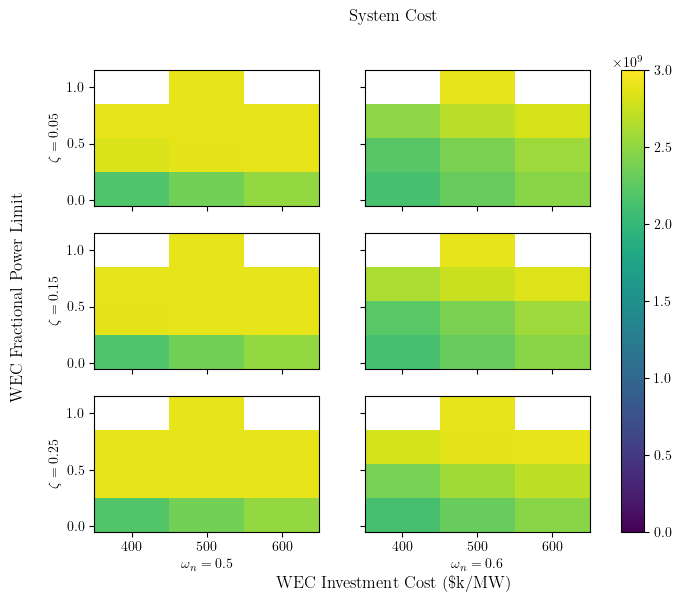

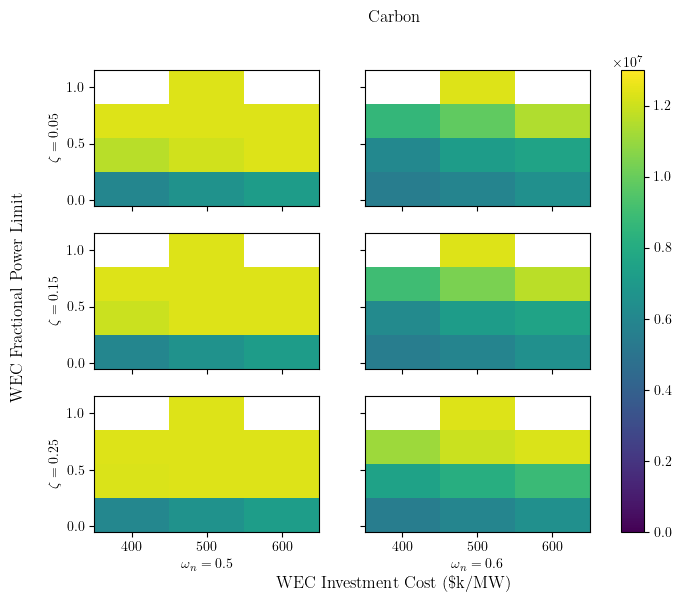

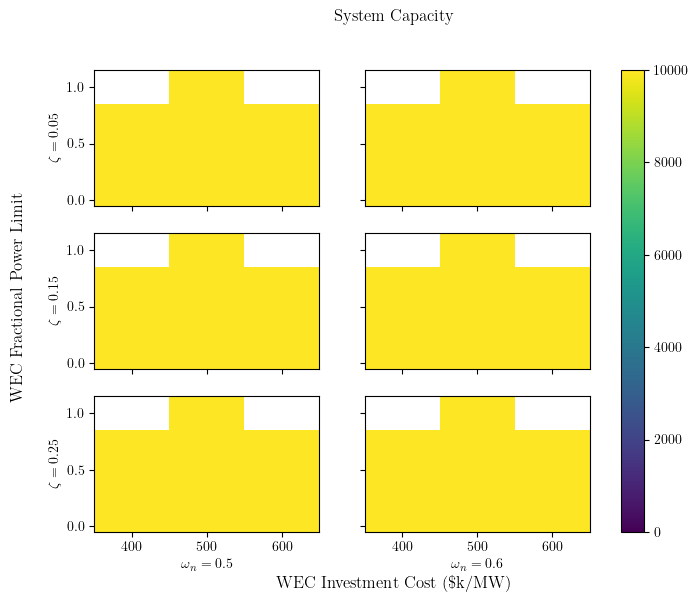

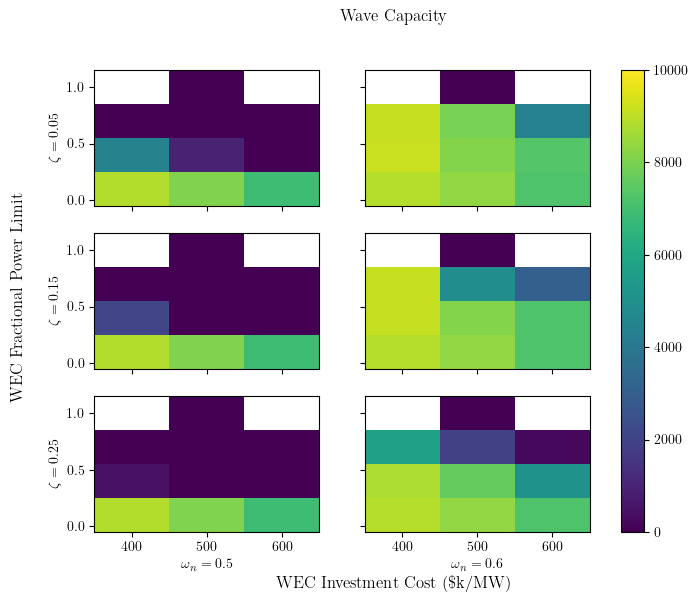

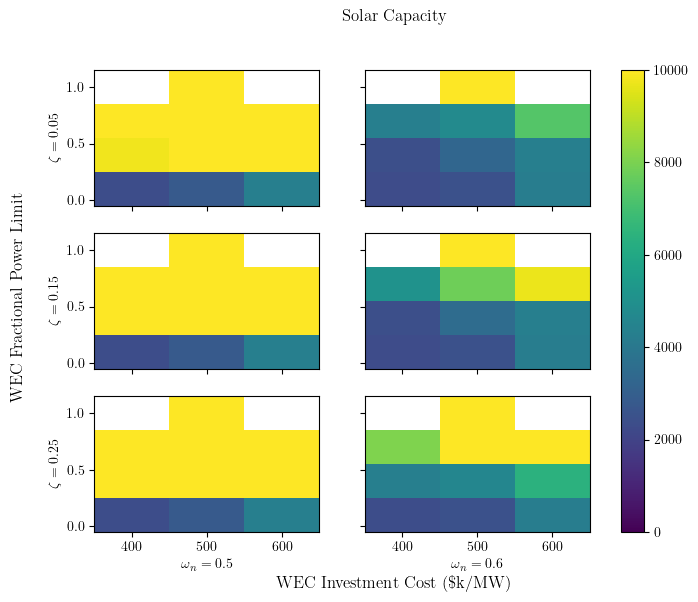

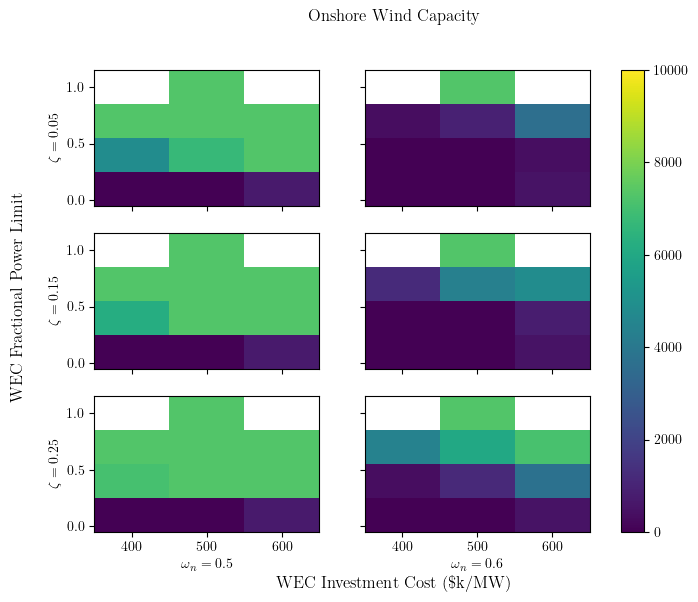

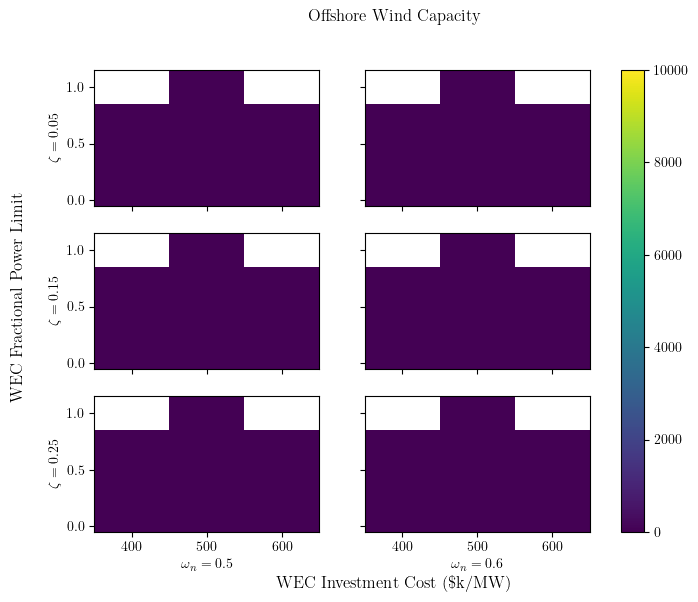

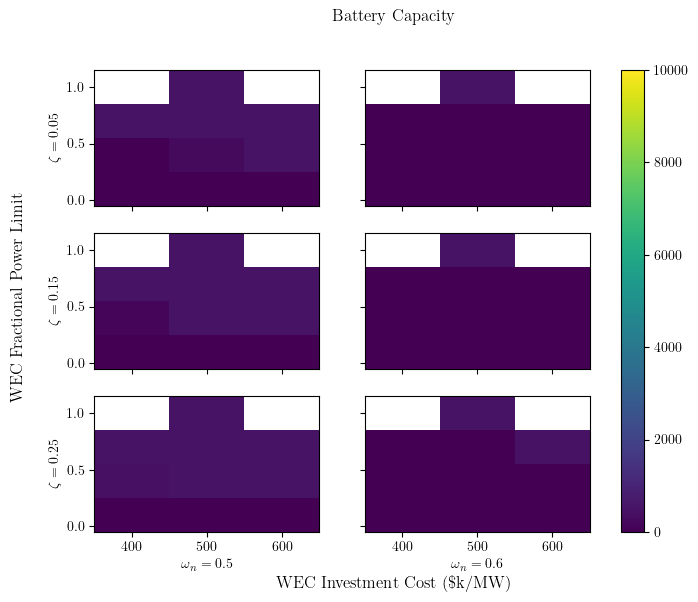

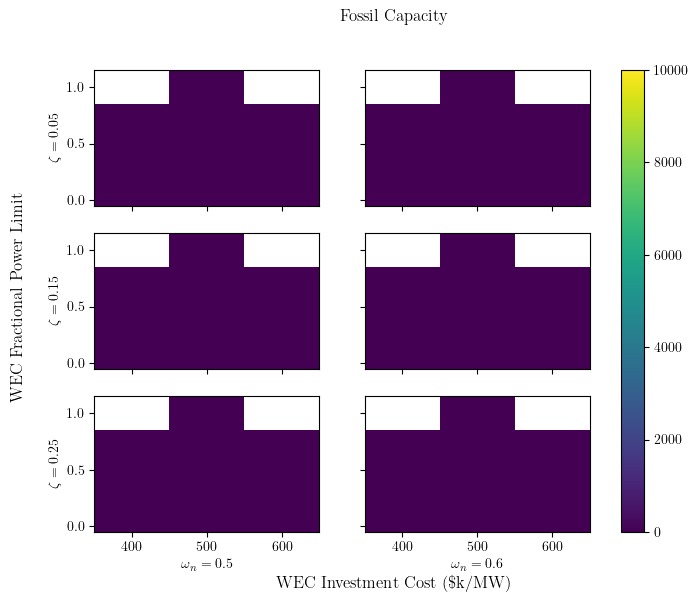

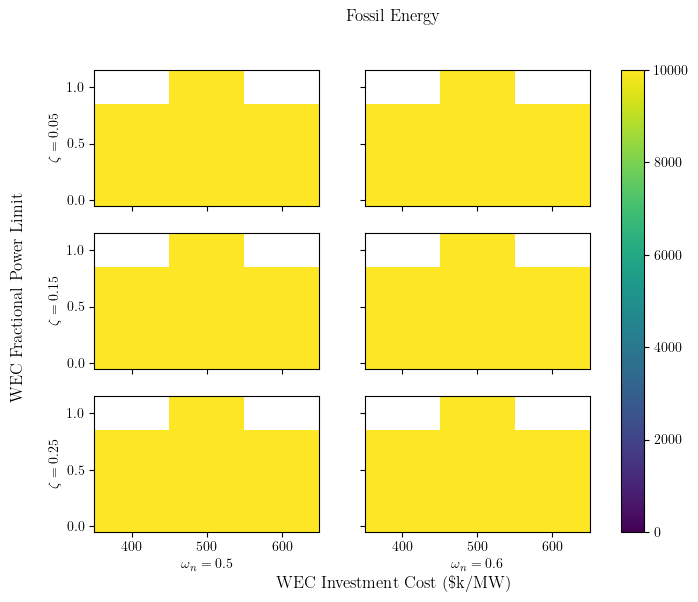

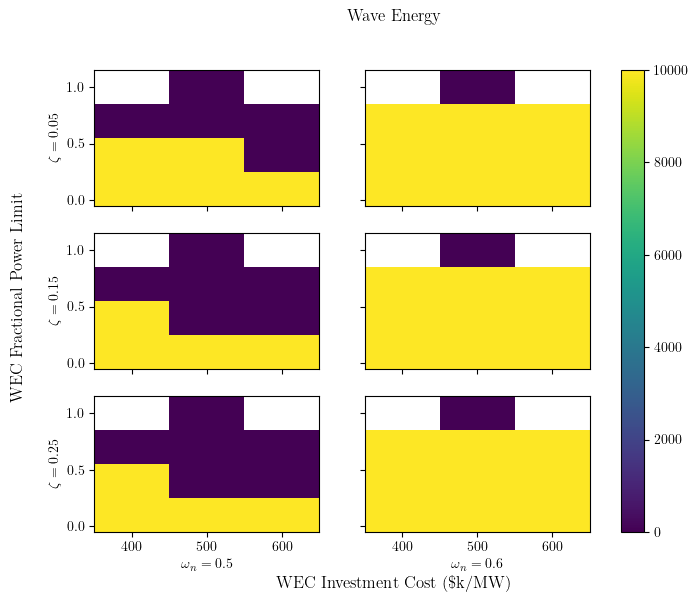

In [203]:
locations = ['data_east']

for location in locations:
    process_one_location(location)